In [1]:
import os, sys, time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = 6, 4

sns.set(rc={"figure.figsize": (6, 4)})
sns.set(style="darkgrid")

print("Numpy version:", np.version.version)

# Set working dir to project root
while not os.getcwd().endswith("lmc"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Training / testing loops

In [4]:
from IPython.display import clear_output

from src.models import TrackedModel, Tracker

def train_epoch(model, optimizer, scheduler = None):
    criterion = nn.CrossEntropyLoss()
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in trainloader:
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        pred = torch.max(output, 1)[1].cpu().numpy()
        acc = np.mean(pred == target.cpu().numpy())
        acc_log.append(acc)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            output = model(data)
            loss = criterion(output, target)

            pred = torch.max(output, 1)[1].cpu().numpy()
            acc = np.mean(pred == target.cpu().numpy())
            acc_log.append(acc)

            loss = loss.item()
            loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title("{}".format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker="+", s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()
    
def train(n_epochs, model, opt, scheduler = None):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, scheduler)

        val_loss, val_acc = test(model, validloader)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(trainset) / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title="accuracy")
        print("Epoch {} valid accuracy = {:.2%}".format(epoch, val_acc_log[-1][1]))
            
    evaluate(model)

def evaluate(model):
    print("Accuracy: {:.2%}".format(np.mean(test(model, testloader)[1])))

def collect_statistics(model: TrackedModel, full: bool = False):
    if full:
        disabled_keys = []
        for key, tracker in model.trackers.items():
            if not tracker.enabled:
                disabled_keys.append(key)
                tracker.enabled = True
    
    model.eval()
    with torch.no_grad(), model.track():
        #it = iter(range(70))
        for x_batch, _ in activation_loader:
            data = x_batch.to(device)
            output = model(data)
            #print(next(it))
    
    if full:
        for key in disabled_keys:
            model[key].enabled = False

## Models

In [5]:
from src.permutation_specs import PermutationSpec
from src.models import MLPModel, mlp_permutation_spec, ConvNetDepth, convnet_permutation_spec

## Permutation methods

### Permutation utils

In [6]:
from torch import Tensor
from typing import NamedTuple, Dict, Sequence

def interpolate(model0: nn.Module, model1: nn.Module, out: nn.Module, alpha: float = 0.5):
    weights0 = model0.state_dict()
    weights1 = model1.state_dict()
    new_weights = {key: (1 - alpha) * weights0[key] + alpha * weights1[key]
                   for key in out.state_dict().keys()}
    out.load_state_dict(new_weights)

def get_permuted_param(model: TrackedModel, permutation_spec: PermutationSpec,
                       permutations: Sequence, key: str, except_axis: int = None) -> Tensor:
    weight = model[key].detach()
    for axis, p in enumerate(permutation_spec.axes2perm[key]):
        if p is None or axis == except_axis:
            continue
        weight = torch.index_select(weight, axis, permutations[p])
    return weight

def apply_permutation(model: TrackedModel, permutation_spec: PermutationSpec,
                      permutations: Sequence):
    for key in permutation_spec.axes2perm:
        model0[key].data = get_permuted_param(model, permutation_spec, permutations, key)

def apply_permutation_stats(model: TrackedModel, permutation_spec: PermutationSpec,
                            permutations: Sequence):
    permuted = set()
    for key, axis_perms in permutation_spec.axes2perm.items():
        key = key.split(".")[0]
        if key in permuted:
            continue
        permuted.add(key)
        if axis_perms[0] is not None:
            model[key].apply_permutation(permutations[axis_perms[0]])

### Activation matching

In [7]:
from scipy.optimize import linear_sum_assignment

def covariance(tracker0: Tracker, tracker1: Tracker):
    outer = 0
    for a0, a1 in zip(tracker0.activations, tracker1.activations):
        outer = outer + (a1.T @ a0) / a0.shape[0]
    outer /= tracker0.num_runs
    cov = outer - torch.outer(tracker1.mean, tracker0.mean)
    return cov

def permute_activations(model0: TrackedModel, model1: TrackedModel,
                        permutation_spec: PermutationSpec,
                        eps: float = 1e-4):
    device = model0[permutation_spec.perm2axes[0][0].key].device
    permutations = []
    for tracker0, tracker1 in zip(model0.trackers.values(), model1.trackers.values()):
        if not tracker0.enabled:
            continue
        
        cov = covariance(tracker0, tracker1)
        corr = cov / (torch.outer(tracker1.std, tracker0.std) + eps)
        
        row_ind, col_ind = linear_sum_assignment(corr.numpy(), maximize=True)
        assert (row_ind == np.arange(corr.shape[0])).all()
        permutations.append(torch.tensor(col_ind, dtype=torch.long, device=device))
        
#         plt.imshow(corr)
#         plt.grid()
#         plt.show()
#         non_diag = corr[~np.diag(np.ones(corr.shape[0], dtype=bool))]
#         print(non_diag.max(), non_diag.mean())
#         assert (col_ind == np.arange(corr.shape[0])).all()
        
    apply_permutation(model0, permutation_spec, permutations)
    apply_permutation_stats(model0, permutation_spec, permutations)

### Weight matching

In [8]:
def permute_weights(model0: TrackedModel, model1: TrackedModel,
                    permutation_spec: PermutationSpec,
                    max_iter: int = 100, eps: float = 1e-12,
                    seed: int = 42):
    set_random_seed(seed)

    device = model0[permutation_spec.perm2axes[0][0].key].device
    perm_sizes = [model0[axes[0].key].shape[axes[0].axis]
                  for axes in permutation_spec.perm2axes]
    permutations = [torch.arange(size, dtype=torch.long, device=device)
                    for size in perm_sizes]
    for iteration in range(max_iter):
        progress = False
        for p in np.random.choice(len(permutations), len(permutations), replace=False):
            size = perm_sizes[p]
            A = torch.zeros((size, size), device=device)
            for key, axis in permutation_spec.perm2axes[p]:
                w1 = model1[key].detach()
                w0 = get_permuted_param(model0, permutation_spec, permutations,
                                        key, except_axis=axis)
                w1 = torch.movedim(w1, axis, 0).reshape(size, -1)
                w0 = torch.movedim(w0, axis, 0).reshape(size, -1)
                A += w1 @ w0.T

            row_ind, col_ind = linear_sum_assignment(A.cpu().numpy(), maximize=True)
            assert (row_ind == np.arange(A.shape[0])).all()
            new_permutation = torch.tensor(col_ind, dtype=torch.long, device=device)

            oldL = torch.diag(A[permutations[p]]).sum()
            newL = torch.diag(A[new_permutation]).sum()
            progress = progress or newL > oldL + eps

            permutations[p] = new_permutation

        if not progress:
            break
    
    apply_permutation(model0, permutation_spec, permutations)

### REPAIR

In [9]:
def repair_closed(model0: TrackedModel, model1: TrackedModel,
                  interpolated: TrackedModel, alpha: float = 0.5):
    for tracker0, tracker1, tracker_i in zip(model0.trackers.values(),
                                             model1.trackers.values(),
                                             interpolated.trackers.values()):
        cov = covariance(tracker0, tracker1)
        rescale = ((1 - alpha) * tracker0.std + alpha * tracker1.std) / \
                  ((1 - alpha) ** 2 * tracker0.var + alpha ** 2 * tracker1.var +
                   2 * alpha * (1 - alpha) * torch.diag(cov)) ** (1 / 2)
        rescale = rescale.to(tracker_i.operator.weight.device)
        
        weight = tracker_i.operator.weight.detach()
        bias = tracker_i.operator.bias.detach()
        tracker_i.operator.weight.data = weight * rescale.view(-1, *([1] * (weight.dim() - 1)))
        tracker_i.operator.bias.data = bias * rescale

def repair_trainmode(interpolated: TrackedModel):
    for tracker in interpolated.trackers.values():
        if "norm" in tracker.operator.__class__.__name__.lower():
            tracker.operator.running_mean = None
            tracker.operator.running_var = None

def repair_sphere(model0: TrackedModel, model1: TrackedModel,
                  interpolated: TrackedModel, alpha: float = 0.5):
    repair_trainmode(interpolated)
    for tracker0, tracker1, tracker_i in zip(model0.trackers.values(),
                                             model1.trackers.values(),
                                             interpolated.trackers.values()):
        norm0 = torch.norm(tracker0.operator.weight.detach())
        norm1 = torch.norm(tracker1.operator.weight.detach())
        norm = (1 - alpha) * norm0 + alpha * norm1
        rescale = norm / torch.norm(tracker_i.operator.weight.detach())
        
        weight = tracker_i.operator.weight.detach()
        bias = tracker_i.operator.bias.detach()
        tracker_i.operator.weight.data = weight * rescale
        tracker_i.operator.bias.data = bias * rescale

## Train two models

In [10]:
checkpoint_dir = "resources/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

data_dir = "/home/sergej/data"
os.makedirs(data_dir, exist_ok=True)

### MNIST

In [11]:
from src.dataset import load_mnist, MNISTDataloader

batch_size = 32

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(data_dir + "/MNIST/raw", flatten=True)
trainset = X_train

trainloader = MNISTDataloader(X_train, y_train, batch_size, shuffle=True)
activation_loader = MNISTDataloader(X_train, y_train, batch_size, shuffle=False)
validloader = MNISTDataloader(X_val, y_val, batch_size, shuffle=False)
testloader = MNISTDataloader(X_test, y_test, batch_size, shuffle=False)

device = "cpu"

In [12]:
from dataclasses import dataclass

@dataclass
class MNISTMLPConfig:
    num_layers = 3
    input_size = 28 * 28
    output_size = 10
    hidden_size = 512
    matching_mode = "pre_activation"

config = MNISTMLPConfig()

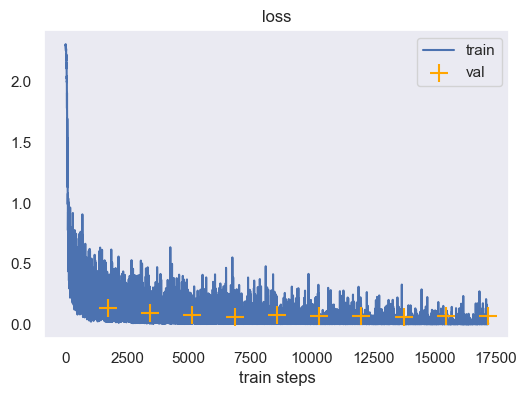

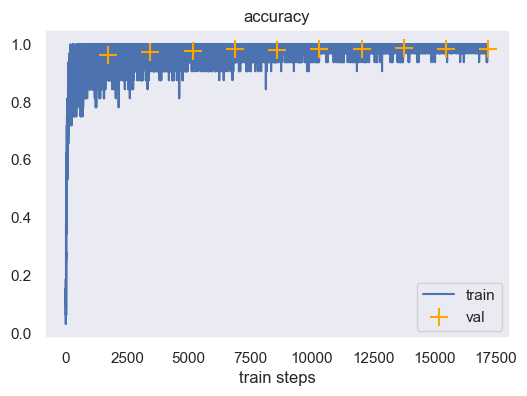

Epoch 9 valid accuracy = 98.50%
Accuracy: 98.28%


In [13]:
set_random_seed(42)

model0 = MLPModel(config)
optim = torch.optim.SGD(model0.parameters(), lr=0.01, momentum=0.9)

train(10, model0, optim)
torch.save(model0.state_dict(), checkpoint_dir + "/mnist_model0.pth")

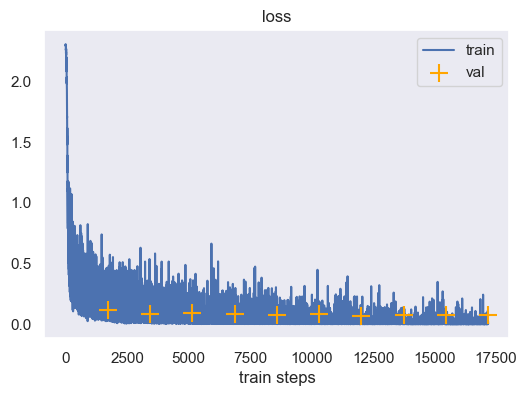

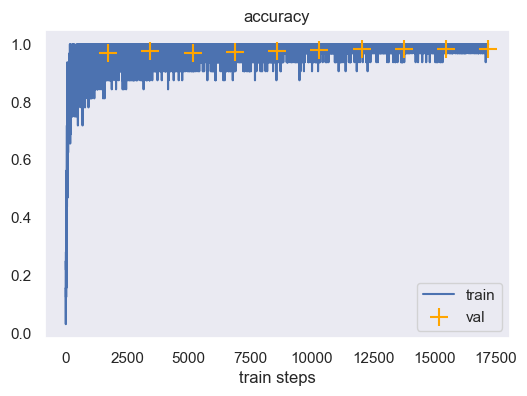

Epoch 9 valid accuracy = 98.30%
Accuracy: 98.01%


In [14]:
set_random_seed(92)

model1 = MLPModel(config)
optim = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

train(10, model1, optim)
torch.save(model1.state_dict(), checkpoint_dir + "/mnist_model1.pth")

### CIFAR10

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128
subset_size = 40 * batch_size

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
trainset, validset = torch.utils.data.random_split(trainset, [45000, 5000],
                                                   generator=torch.Generator().manual_seed(42))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
activation_subset = torch.utils.data.Subset(trainset, list(range(subset_size)))
activation_loader = torch.utils.data.DataLoader(activation_subset, batch_size=batch_size,
                                                shuffle=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False)

testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

device = "cuda:0"

Files already downloaded and verified
Files already downloaded and verified


In [12]:
from dataclasses import dataclass

@dataclass
class CIFARMLPConfig:
    num_layers = 4
    input_size = 32 * 32 * 3
    output_size = 10
    hidden_size = 512
    matching_mode = "pre_activation"

config = CIFARMLPConfig()

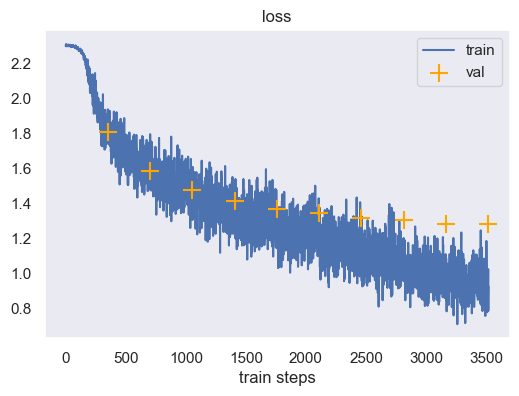

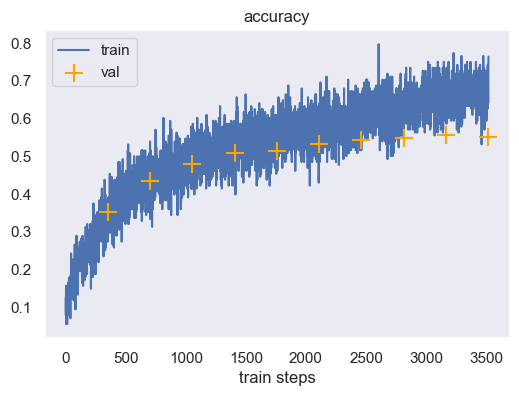

Epoch 9 valid accuracy = 55.14%
Accuracy: 55.14%


In [13]:
set_random_seed(42)

lr = 0.01
num_epochs = 10

model0 = MLPModel(config)
model0.to(device)
optim = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model0, optim, scheduler)
torch.save(model0.state_dict(), checkpoint_dir + "/cifar_model0.pth")

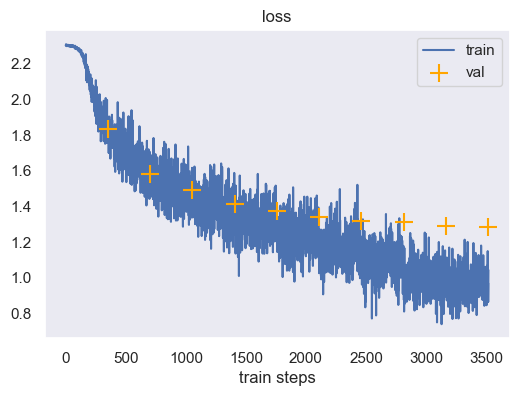

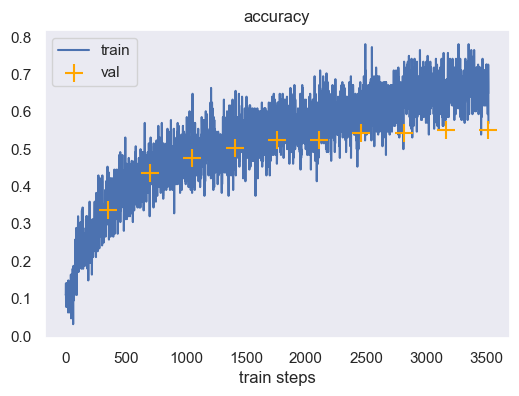

Epoch 9 valid accuracy = 55.23%
Accuracy: 55.58%


In [14]:
set_random_seed(92)

lr = 0.01
num_epochs = 10

model1 = MLPModel(config)
model1.to(device)
optim = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model1, optim, scheduler)
torch.save(model1.state_dict(), checkpoint_dir + "/cifar_model1.pth")

In [12]:
from dataclasses import dataclass

@dataclass
class CIFARConvNetConfig:
    init_channels = 64
    num_classes = 10
    max_depth = 3
    matching_mode = "pre_activation"

config = CIFARConvNetConfig()

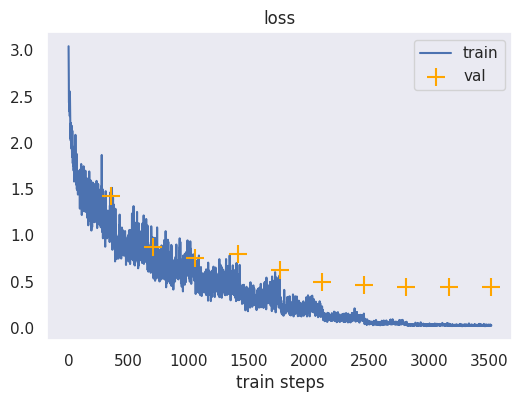

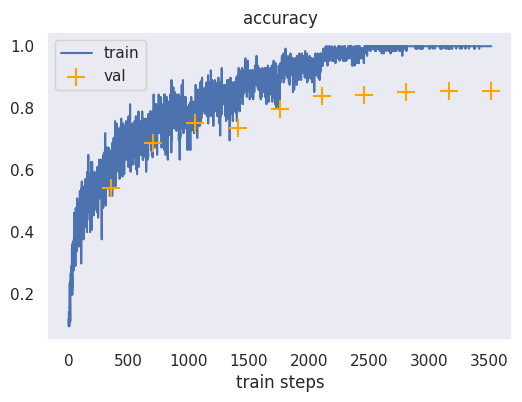

Epoch 9 valid accuracy = 85.53%
Accuracy: 84.71%


In [13]:
set_random_seed(42)

lr = 1e-2
num_epochs = 10

model0 = ConvNetDepth(config)
model0.to(device)
optim = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model0, optim, scheduler)
torch.save(model0.state_dict(), checkpoint_dir + "/cifar_conv0.pth")

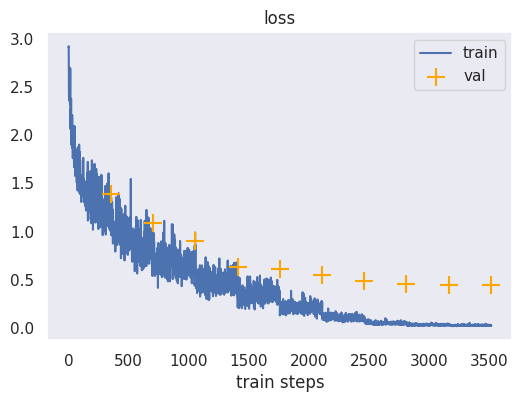

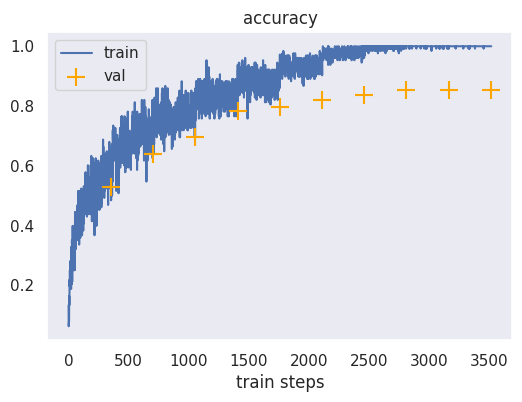

Epoch 9 valid accuracy = 85.49%
Accuracy: 84.28%


In [14]:
set_random_seed(92)

lr = 1e-2
num_epochs = 10

model1 = ConvNetDepth(config)
model1.to(device)
optim = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model1, optim, scheduler)
torch.save(model1.state_dict(), checkpoint_dir + "/cifar_conv1.pth")

## Permute the weights of model 0 to align with model 1

In [13]:
from tqdm.auto import tqdm

def get_test_interpolation(model0, model1, alphas = np.linspace(0, 1, 25), repair = "none"):
    interpolated = model0.copy()
    interpolated = interpolated.to(device)
    accuracies = []
    losses = []
    for alpha in tqdm(alphas, desc="Interpolate"):
        interpolate(model0, model1, interpolated, alpha)
        if repair == "closed":
            repair_closed(model0, model1, interpolated, alpha)
        elif repair == "trainmode":
            repair_trainmode(interpolated)
        elif repair == "sphere":
            repair_sphere(model0, model1, interpolated, alpha)
        loss, accuracy = test(interpolated, testloader)
        accuracies += [np.mean(accuracy)]
        losses += [np.mean(loss)]

    return accuracies, losses, alphas

def get_variance(model):
    return np.array([
        tracker.var.mean().item() for tracker in model.trackers.values()
    ], dtype=float)

def reload_models():
    global model0, model1
    
    if model_type == "mlp":
        model0 = MLPModel(config)
        model0.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_model0.pth"))
        model0.to(device)
        model1 = MLPModel(config)
        model1.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_model1.pth"))
        model1.to(device)
    elif model_type == "conv":
        model0 = ConvNetDepth(config)
        model0.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_conv0.pth"))
        model0.to(device)
        model1 = ConvNetDepth(config)
        model1.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_conv1.pth"))
        model1.to(device)

def activation_matching():
    reload_models()
    for model in [model0, model1]:
        collect_statistics(model, full=True)
    permute_activations(model0, model1, perm_spec)

def weight_matching():
    reload_models()
    permute_weights(model0, model1, perm_spec)

### MNIST

In [14]:
config = MNISTMLPConfig()
perm_spec = mlp_permutation_spec(config)
dataset_name = "mnist"
model_type = "mlp"

In [16]:
reload_models()
accs, losses, alphas = get_test_interpolation(model0, model1)
activation_matching()
pre_act_accs, pre_act_losses, _ = get_test_interpolation(model0, model)
pre_act_rep_accs, pre_act_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")
weight_matching()
weight_accs, weight_losses, _ = get_test_interpolation(model0, model1)
for model in [model0, model1]:
    collect_statistics(model, full=True)
weight_rep_accs, weight_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

config.matching_mode = "post_activation"
activation_matching()
post_act_accs, post_act_losses, _ = get_test_interpolation(model0, model1)
post_act_rep_accs, post_act_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

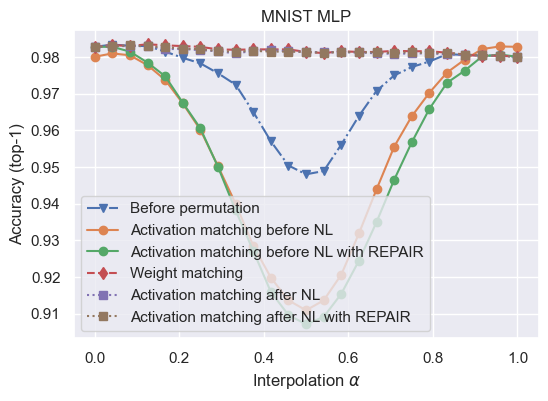

In [18]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_accs, label="Activation matching before NL", marker="o")
plt.plot(alphas, pre_act_rep_accs, label="Activation matching before NL with REPAIR", marker="o")
plt.plot(alphas, weight_accs, label="Weight matching", marker="d", linestyle="--")
# plt.plot(alphas, weight_rep_accs, label="Weight matching with REPAIR", marker="d", linestyle="--")
plt.plot(alphas, post_act_accs, label="Activation matching after NL", marker="s", linestyle=":")
plt.plot(alphas, post_act_rep_accs, label="Activation matching after NL with REPAIR", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("MNIST MLP")
plt.show()

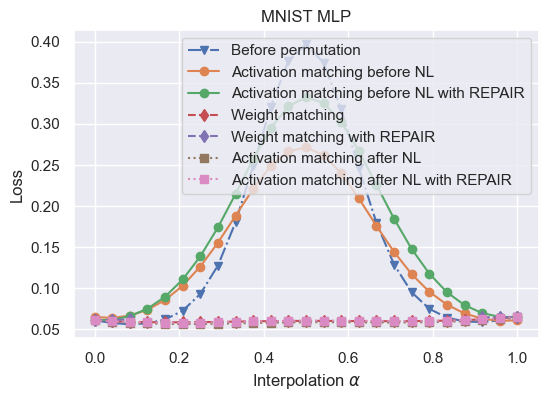

In [19]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_losses, label="Activation matching before NL", marker="o")
plt.plot(alphas, pre_act_rep_losses, label="Activation matching before NL with REPAIR", marker="o")
plt.plot(alphas, weight_losses, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_losses, label="Weight matching with REPAIR", marker="d", linestyle="--")
plt.plot(alphas, post_act_losses, label="Activation matching after NL", marker="s", linestyle=":")
plt.plot(alphas, post_act_rep_losses, label="Activation matching after NL with REPAIR", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("MNIST MLP")
plt.show()

In [20]:
%timeit activation_matching()

7.42 s ± 802 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit weight_matching()

145 ms ± 6.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### REPAIR

In [15]:
config = MNISTMLPConfig()
config.matching_mode = "pre_activation"

reload_models()
for model in [model0, model1]:
    collect_statistics(model, full=True)
orig_var = get_variance(model0)

permute_activations(model0, model1, perm_spec)

interpolated = model0.copy()
interpolated = interpolated.to(device)
interpolate(model0, model1, interpolated)
collect_statistics(interpolated, full=True)
rel_var = get_variance(interpolated) / orig_var

repair_closed(model0, model1, interpolated)

collect_statistics(interpolated, full=True)
rep_var = get_variance(interpolated) / orig_var

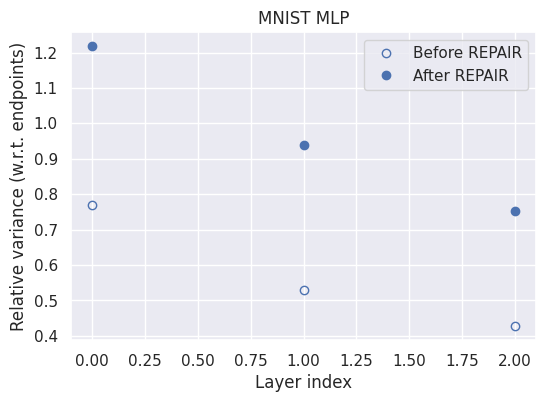

In [16]:
plt.plot(rel_var, label="Before REPAIR", marker="o", linestyle="none",
         markerfacecolor="none", color=sns.color_palette()[0])
plt.plot(rep_var, label="After REPAIR", marker="o", linestyle="none",
         color=sns.color_palette()[0])
plt.xlabel("Layer index")
plt.ylabel("Relative variance (w.r.t. endpoints)")
plt.legend()
plt.title("MNIST MLP")
plt.show()

### CIFAR10

In [15]:
config = CIFARMLPConfig()
perm_spec = mlp_permutation_spec(config)
dataset_name = "cifar"
model_type = "mlp"

In [21]:
reload_models()
accs, losses, alphas = get_test_interpolation(model0, model1)
activation_matching()
pre_act_accs, pre_act_losses, _ = get_test_interpolation(model0, model1)
pre_act_rep_accs, pre_act_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")
weight_matching()
weight_accs, weight_losses, _ = get_test_interpolation(model0, model1)
for model in [model0, model1]:
    collect_statistics(model, full=True)
weight_rep_accs, weight_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

config.matching_mode = "post_activation"
activation_matching()
post_act_accs, post_act_losses, _ = get_test_interpolation(model0, model1)
post_act_rep_accs, post_act_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

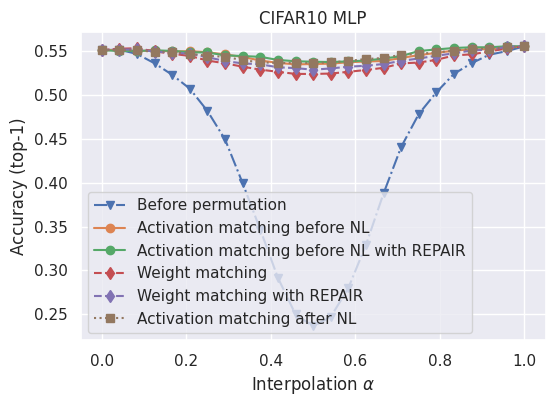

In [22]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_accs, label="Activation matching before NL", marker="o")
plt.plot(alphas, pre_act_rep_accs, label="Activation matching before NL with REPAIR", marker="o")
plt.plot(alphas, weight_accs, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_accs, label="Weight matching with REPAIR", marker="d", linestyle="--")
plt.plot(alphas, post_act_accs, label="Activation matching after NL", marker="s", linestyle=":")
# plt.plot(alphas, post_act_rep_accs, label="Activation matching after NL with REPAIR", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 MLP")
plt.show()

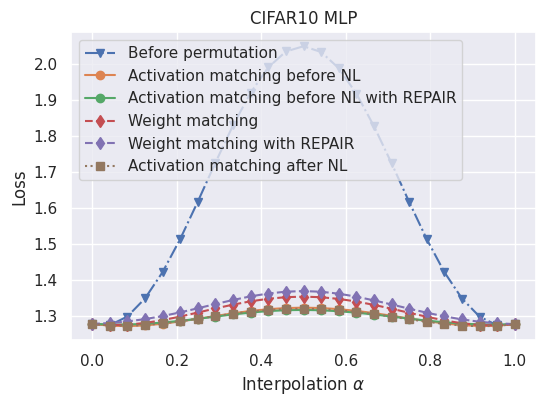

In [23]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_losses, label="Activation matching before NL", marker="o")
plt.plot(alphas, pre_act_rep_losses, label="Activation matching before NL with REPAIR", marker="o")
plt.plot(alphas, weight_losses, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_losses, label="Weight matching with REPAIR", marker="d", linestyle="--")
plt.plot(alphas, post_act_losses, label="Activation matching after NL", marker="s", linestyle=":")
# plt.plot(alphas, post_act_rep_losses, label="Activation matching after NL with REPAIR", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 MLP")
plt.show()

Nvidia GTX 1050 2GB

In [23]:
%timeit activation_matching()

42.1 s ± 3.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit weight_matching()

160 ms ± 9.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Nvidia RTX 3090 24GB

In [16]:
%timeit activation_matching()

5.74 s ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit weight_matching()

182 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### ConvNet

In [14]:
config = CIFARConvNetConfig()
perm_spec = convnet_permutation_spec(config)
dataset_name = "cifar"
model_type = "conv"

In [15]:
import gc

reload_models()
accs, losses, alphas = get_test_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_test_interpolation(model0, model1, repair="trainmode")
accs_sph, losses_sph, _ = get_test_interpolation(model0, model1, repair="sphere")
for model in [model0, model1]:
    collect_statistics(model, full=True)
accs_rep, losses_rep, _ = get_test_interpolation(model0, model1, repair="closed")

del model0
del model1
del model
gc.collect()

activation_matching()
pre_act_accs, pre_act_losses, _ = get_test_interpolation(model0, model1)
pre_act_tr_accs, pre_act_tr_losses, _ = get_test_interpolation(model0, model1, repair="trainmode")
pre_act_sph_accs, pre_act_sph_losses, _ = get_test_interpolation(model0, model1, repair="sphere")
pre_act_rep_accs, pre_act_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

del model0
del model1
gc.collect()

weight_matching()
weight_accs, weight_losses, _ = get_test_interpolation(model0, model1)
weight_tr_accs, weight_tr_losses, _ = get_test_interpolation(model0, model1, repair="trainmode")
weight_sph_accs, weight_sph_losses, _ = get_test_interpolation(model0, model1, repair="sphere")
for model in [model0, model1]:
    collect_statistics(model, full=True)
weight_rep_accs, weight_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

del model0
del model1
del model
gc.collect()

config.matching_mode = "post_activation"
activation_matching()
post_act_accs, post_act_losses, _ = get_test_interpolation(model0, model1)
post_act_tr_accs, post_act_tr_losses, _ = get_test_interpolation(model0, model1, repair="trainmode")
post_act_sph_accs, post_act_sph_losses, _ = get_test_interpolation(model0, model1, repair="sphere")
post_act_rep_accs, post_act_rep_losses, _ = get_test_interpolation(model0, model1, repair="closed")

del model0
del model1
gc.collect()

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

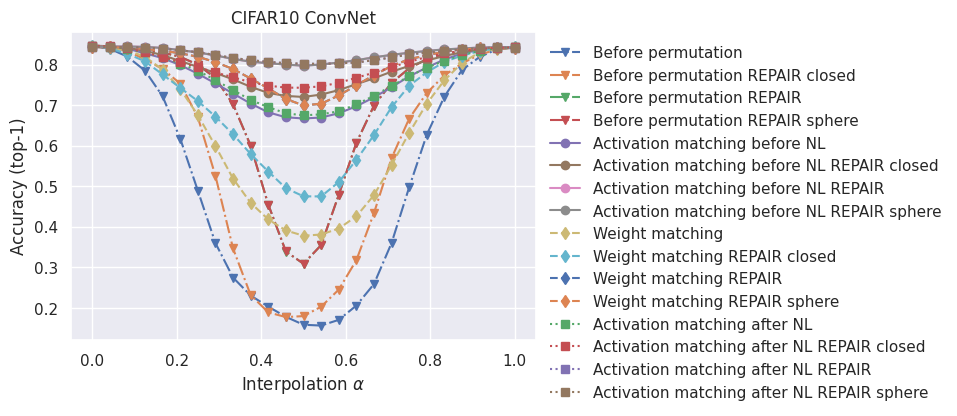

In [16]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, accs_rep, label="Before permutation REPAIR closed", marker="v", linestyle="-.")
plt.plot(alphas, accs_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
plt.plot(alphas, accs_sph, label="Before permutation REPAIR sphere", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_accs, label="Activation matching before NL", marker="o")
plt.plot(alphas, pre_act_rep_accs, label="Activation matching before NL REPAIR closed", marker="o")
plt.plot(alphas, pre_act_tr_accs, label="Activation matching before NL REPAIR", marker="o")
plt.plot(alphas, pre_act_sph_accs, label="Activation matching before NL REPAIR sphere", marker="o")
plt.plot(alphas, weight_accs, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_accs, label="Weight matching REPAIR closed", marker="d", linestyle="--")
plt.plot(alphas, weight_tr_accs, label="Weight matching REPAIR", marker="d", linestyle="--")
plt.plot(alphas, weight_sph_accs, label="Weight matching REPAIR sphere", marker="d", linestyle="--")
plt.plot(alphas, post_act_accs, label="Activation matching after NL", marker="s", linestyle=":")
plt.plot(alphas, post_act_rep_accs, label="Activation matching after NL REPAIR closed", marker="s", linestyle=":")
plt.plot(alphas, post_act_tr_accs, label="Activation matching after NL REPAIR", marker="s", linestyle=":")
plt.plot(alphas, post_act_sph_accs, label="Activation matching after NL REPAIR sphere", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

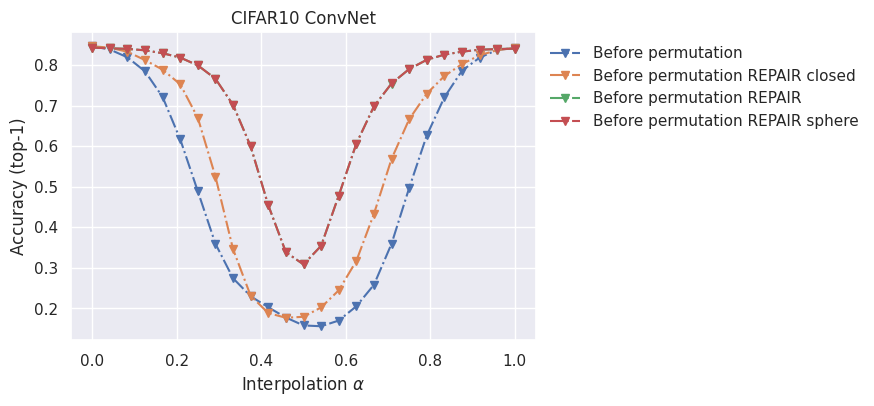

In [19]:
plt.plot(alphas, accs, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, accs_rep, label="Before permutation REPAIR closed", marker="v", linestyle="-.")
plt.plot(alphas, accs_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
plt.plot(alphas, accs_sph, label="Before permutation REPAIR sphere", marker="v", linestyle="-.")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

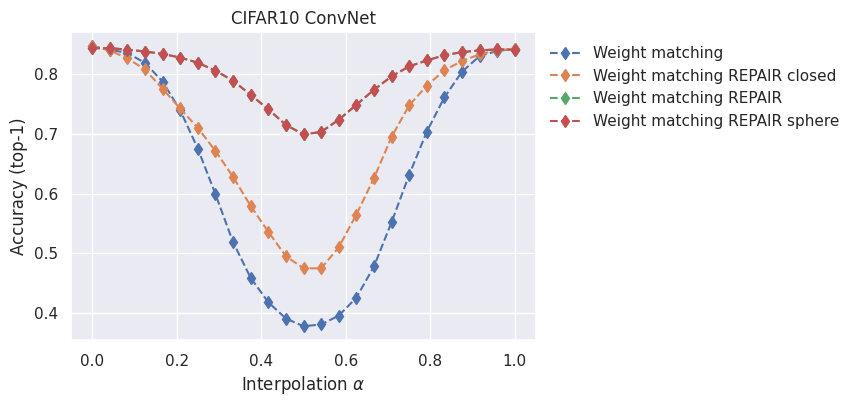

In [20]:
plt.plot(alphas, weight_accs, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_accs, label="Weight matching REPAIR closed", marker="d", linestyle="--")
plt.plot(alphas, weight_tr_accs, label="Weight matching REPAIR", marker="d", linestyle="--")
plt.plot(alphas, weight_sph_accs, label="Weight matching REPAIR sphere", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

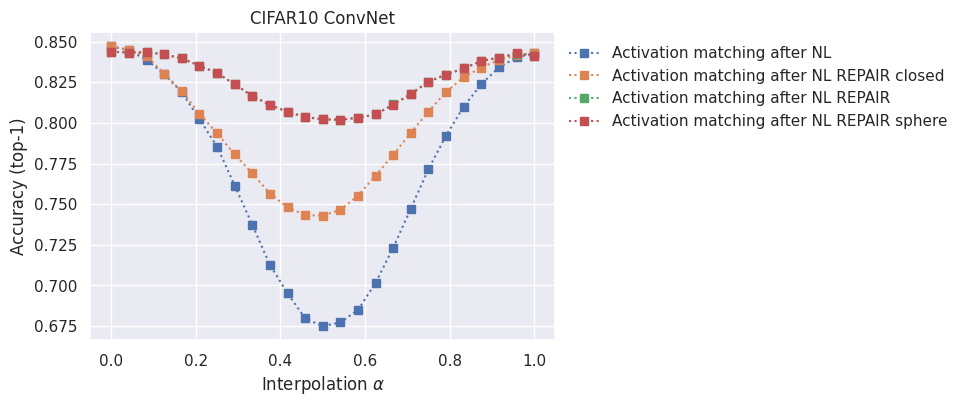

In [23]:
plt.plot(alphas, post_act_accs, label="Activation matching after NL", marker="s", linestyle=":")
plt.plot(alphas, post_act_rep_accs, label="Activation matching after NL REPAIR closed", marker="s", linestyle=":")
plt.plot(alphas, post_act_tr_accs, label="Activation matching after NL REPAIR", marker="s", linestyle=":")
plt.plot(alphas, post_act_sph_accs, label="Activation matching after NL REPAIR sphere", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Accuracy (top-1)")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

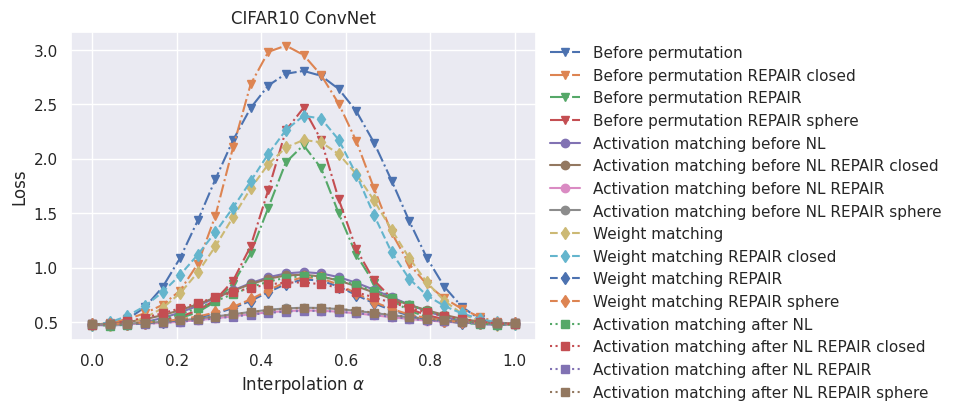

In [22]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, losses_rep, label="Before permutation REPAIR closed", marker="v", linestyle="-.")
plt.plot(alphas, losses_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
plt.plot(alphas, losses_sph, label="Before permutation REPAIR sphere", marker="v", linestyle="-.")
plt.plot(alphas, pre_act_losses, label="Activation matching before NL", marker="o")
plt.plot(alphas, pre_act_rep_losses, label="Activation matching before NL REPAIR closed", marker="o")
plt.plot(alphas, pre_act_tr_losses, label="Activation matching before NL REPAIR", marker="o")
plt.plot(alphas, pre_act_sph_losses, label="Activation matching before NL REPAIR sphere", marker="o")
plt.plot(alphas, weight_losses, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_losses, label="Weight matching REPAIR closed", marker="d", linestyle="--")
plt.plot(alphas, weight_tr_losses, label="Weight matching REPAIR", marker="d", linestyle="--")
plt.plot(alphas, weight_sph_losses, label="Weight matching REPAIR sphere", marker="d", linestyle="--")
plt.plot(alphas, post_act_losses, label="Activation matching after NL", marker="s", linestyle=":")
plt.plot(alphas, post_act_rep_losses, label="Activation matching after NL REPAIR closed", marker="s", linestyle=":")
plt.plot(alphas, post_act_tr_losses, label="Activation matching after NL REPAIR", marker="s", linestyle=":")
plt.plot(alphas, post_act_sph_losses, label="Activation matching after NL REPAIR sphere", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

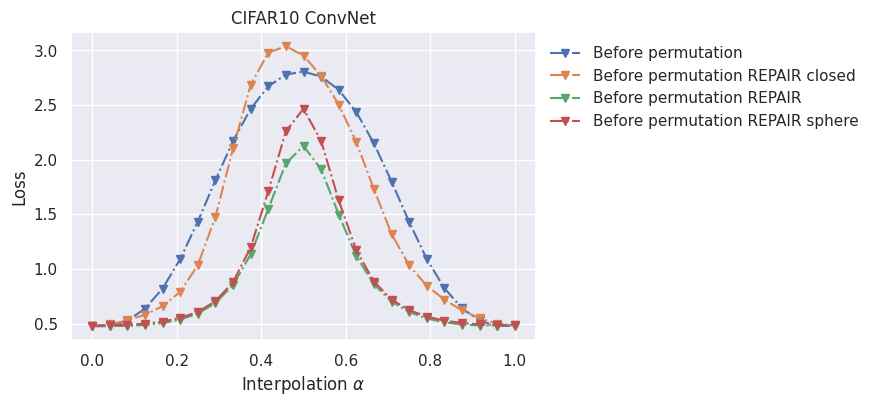

In [24]:
plt.plot(alphas, losses, label="Before permutation", marker="v", linestyle="-.")
plt.plot(alphas, losses_rep, label="Before permutation REPAIR closed", marker="v", linestyle="-.")
plt.plot(alphas, losses_tr, label="Before permutation REPAIR", marker="v", linestyle="-.")
plt.plot(alphas, losses_sph, label="Before permutation REPAIR sphere", marker="v", linestyle="-.")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

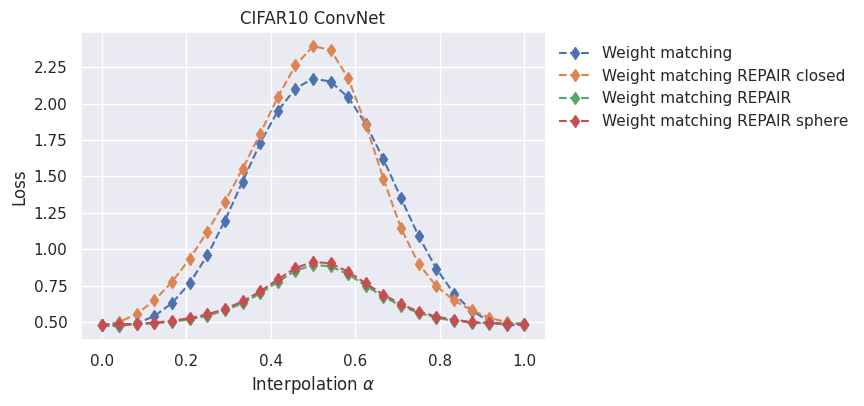

In [25]:
plt.plot(alphas, weight_losses, label="Weight matching", marker="d", linestyle="--")
plt.plot(alphas, weight_rep_losses, label="Weight matching REPAIR closed", marker="d", linestyle="--")
plt.plot(alphas, weight_tr_losses, label="Weight matching REPAIR", marker="d", linestyle="--")
plt.plot(alphas, weight_sph_losses, label="Weight matching REPAIR sphere", marker="d", linestyle="--")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()

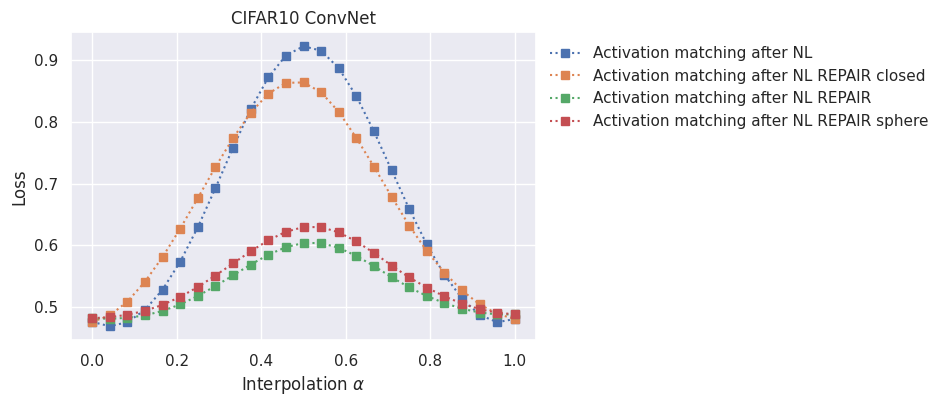

In [26]:
plt.plot(alphas, post_act_losses, label="Activation matching after NL", marker="s", linestyle=":")
plt.plot(alphas, post_act_rep_losses, label="Activation matching after NL REPAIR closed", marker="s", linestyle=":")
plt.plot(alphas, post_act_tr_losses, label="Activation matching after NL REPAIR", marker="s", linestyle=":")
plt.plot(alphas, post_act_sph_losses, label="Activation matching after NL REPAIR sphere", marker="s", linestyle=":")
plt.xlabel("Interpolation $\\alpha$")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet")
plt.show()